# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import math

from matplotlib.pylab import plt


# Load CIFAR-10 Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
image_idx = 1
images = np.expand_dims(x_train[image_idx], 0) / 255.0 # x_train[:10]


training_dataset :  (50000, 32, 32, 3) (50000, 1)
training_dataset :  (10000, 32, 32, 3) (10000, 1)
min of pixel value :  0.0196078431372549
max of pixel value :  0.996078431372549


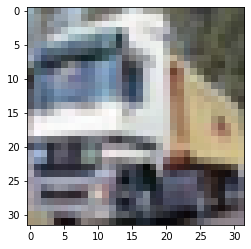

In [3]:
print('training_dataset : ', x_train.shape, y_train.shape)
print('training_dataset : ', x_test.shape, y_test.shape)
print('min of pixel value : ',np.min(images))
print('max of pixel value : ',np.max(images))
plt.imshow(images[0])

# Gaussian Filter

In [4]:
def create_gaussian_filter(m, sigma):
    matrix = np.zeros((m,m,3,3), dtype=np.float)
    r_center = int(m/2)
    c_center = int(m/2)

    for r in range(m):
        for c in range(m):
            dr = r - r_center
            dc = c - c_center
            for ch in range(3):
                matrix[r][c][ch][ch] = 1 / (2*math.pi*sigma*sigma) * math.exp(-(dr*dr+dc*dc)/(2*sigma*sigma))

    matrix_sum_r = np.sum(matrix[:,:,0,0])
    matrix_sum_g = np.sum(matrix[:,:,1,1])
    matrix_sum_b = np.sum(matrix[:,:,2,2])
    for r in range(m):
        for c in range(m):
            matrix[r][c][0][0] /= (matrix_sum_r)
            matrix[r][c][1][1] /= (matrix_sum_g)
            matrix[r][c][2][2] /= (matrix_sum_b)
    
    return matrix

def create_gaussian_filter_channelwise(m, sigma):
    matrix = np.zeros((m,m,1,1), dtype=np.float)
    r_center = int(m/2)
    c_center = int(m/2)

    for r in range(m):
        for c in range(m):
            dr = r - r_center
            dc = c - c_center
            matrix[r][c][0][0] = 1 / (2*math.pi*sigma*sigma) * math.exp(-(dr*dr+dc*dc)/(2*sigma*sigma))
    
    matrix_sum = np.sum(matrix)
    for r in range(m):
        for c in range(m):
            matrix[r][c][0][0] /= matrix_sum
            
    return matrix

In [5]:
sizes = [3,7,15]
sigmas = [1,3,5]

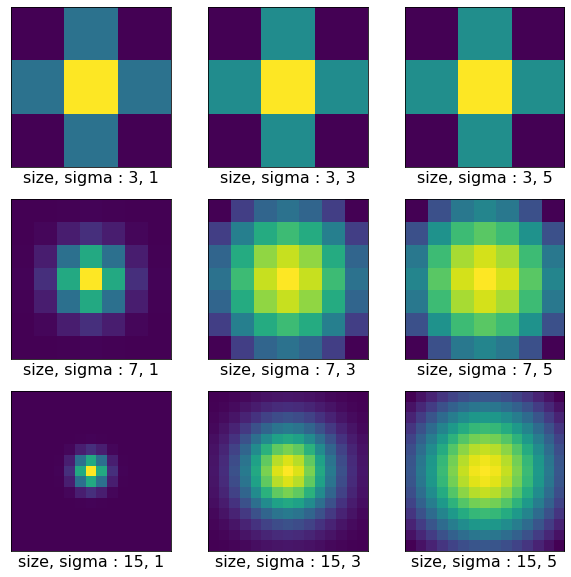

In [6]:
fig = plt.figure(figsize=(10,10))
rows = len(sizes)
cols = len(sigmas)
for r, size in enumerate(sizes):
    for c, sigma in enumerate(sigmas):
        idx = r*cols+ c + 1
        filter = create_gaussian_filter(size, sigma)
        
        ax = fig.add_subplot(rows, cols, idx)
        ax.imshow(filter[:,:,0,0])
        ax.set_xlabel("size, sigma : " + str(size) + ", " + str(sigma), fontsize=16)
        ax.set_xticks([]), ax.set_yticks([])

plt.show()

# Results

### - Single Convolution

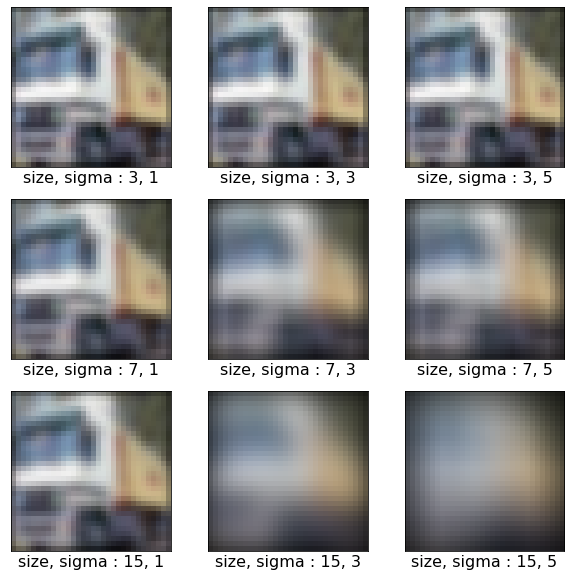

In [7]:
fig = plt.figure(figsize=(10,10))
rows = len(sizes)
cols = len(sigmas)
for r, size in enumerate(sizes):
    for c, sigma in enumerate(sigmas):
        idx = r*cols+ c + 1
        filter = create_gaussian_filter(size, sigma)
        result = tf.nn.conv2d(images, filter, strides=[1, 1, 1, 1], padding="SAME")
        
        ax = fig.add_subplot(rows, cols, idx)
        ax.imshow(result[0])
        ax.set_xlabel("size, sigma : " + str(size) + ", " + str(sigma), fontsize=16)
        ax.set_xticks([]), ax.set_yticks([])

plt.show()


### - Three Channelwise Convolutions

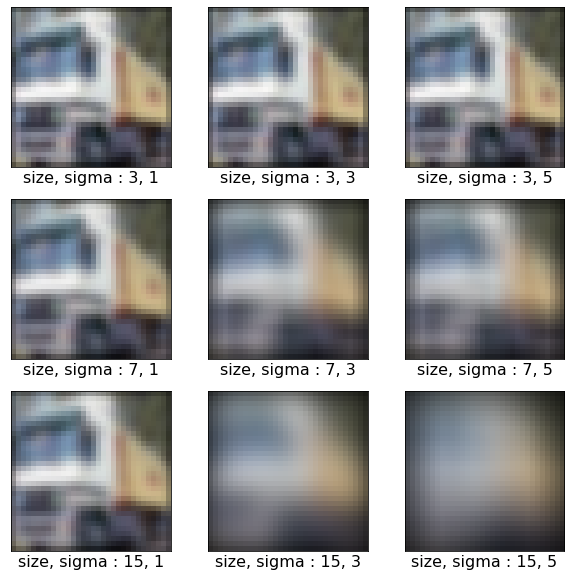

In [8]:
fig = plt.figure(figsize=(10,10))
rows = len(sizes)
cols = len(sigmas)
for r, size in enumerate(sizes):
    for c, sigma in enumerate(sigmas):
        idx = r*cols+ c + 1
        filter = create_gaussian_filter_channelwise(size, sigma)
        result_r = tf.nn.conv2d(images[:,:,:,:1], filter, strides=[1, 1, 1, 1], padding="SAME")
        result_g = tf.nn.conv2d(images[:,:,:,1:2], filter, strides=[1, 1, 1, 1], padding="SAME")
        result_b = tf.nn.conv2d(images[:,:,:,2:3], filter, strides=[1, 1, 1, 1], padding="SAME")
        result = np.concatenate((result_r, result_g, result_b), axis=3)
        ax = fig.add_subplot(rows, cols, idx)
        ax.imshow(result[0])
        ax.set_xlabel("size, sigma : " + str(size) + ", " + str(sigma), fontsize=16)
        ax.set_xticks([]), ax.set_yticks([])

plt.show()


# Additional Experiments - Compare Inference Time

In [16]:
import time
images = x_train[:1000] / 255.0

### a) Single Convolution

In [17]:
start_t = time.time()

rows = len(sizes)
cols = len(sigmas)
for r, size in enumerate(sizes):
    for c, sigma in enumerate(sigmas):
        idx = r*cols+ c + 1
        filter = create_gaussian_filter(size, sigma)
        result = tf.nn.conv2d(images, filter, strides=[1, 1, 1, 1], padding="SAME")

end_t = time.time()

print(end_t - start_t)

1.9408259391784668


### b) Three Channelwise Convolutions

In [19]:
start_t = time.time()

rows = len(sizes)
cols = len(sigmas)
for r, size in enumerate(sizes):
    for c, sigma in enumerate(sigmas):
        idx = r*cols+ c + 1
        filter = create_gaussian_filter_channelwise(size, sigma)
        result_r = tf.nn.conv2d(images[:,:,:,:1], filter, strides=[1, 1, 1, 1], padding="SAME")
        result_g = tf.nn.conv2d(images[:,:,:,1:2], filter, strides=[1, 1, 1, 1], padding="SAME")
        result_b = tf.nn.conv2d(images[:,:,:,2:3], filter, strides=[1, 1, 1, 1], padding="SAME")
        result = np.concatenate((result_r, result_g, result_b), axis=3)

end_t = time.time()

print(end_t - start_t)

2.6479172706604004


# Additional Experiments - Compare filter Quality

In [12]:
images = np.expand_dims(x_train[image_idx], 0) / 255.0 # x_train[:10]
iters = [4, 2, 1]

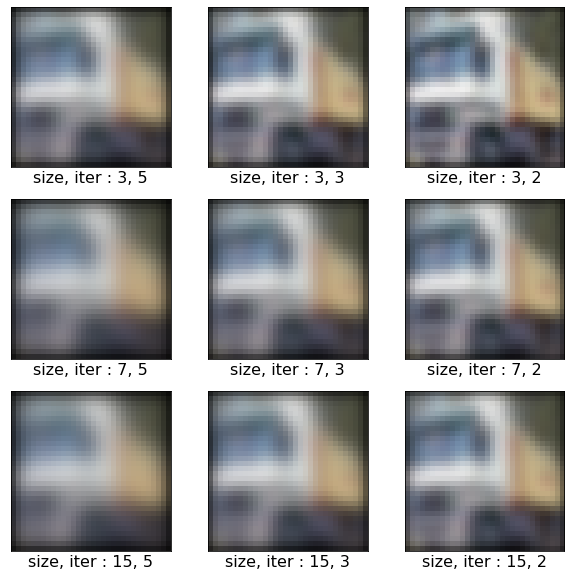

In [13]:
fig = plt.figure(figsize=(10,10))
rows = len(sizes)
cols = len(sigmas)
for r, size in enumerate(sizes):
    for c, it in enumerate(iters):
        idx = r*cols+ c + 1
        filter = create_gaussian_filter(size, 1)
        result = tf.nn.conv2d(images, filter, strides=[1, 1, 1, 1], padding="SAME")
        for _ in range(it):
            result = tf.nn.conv2d(result, filter, strides=[1, 1, 1, 1], padding="SAME")
        
        ax = fig.add_subplot(rows, cols, idx)
        ax.imshow(result[0])
        ax.set_xlabel("size, iter : " + str(size) + ", " + str(it+1), fontsize=16)
        ax.set_xticks([]), ax.set_yticks([])

plt.show()
